# Read Gamma + Muons Simulation and Fit to Lab Data + Smear

### Import needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal

import ROOT
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import matplotlib as mpl
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# import deDisperse_util as util
import matplotlib.colors as colors

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
mpl.style.use('seaborn-colorblind')

from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver
ped = 50 #pedestal correction

from langaus import LanGausFit # Import Langaus fit curve for PyROOT.
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02
/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


/tmp/ipykernel_4774/1070356883.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


### Import Simulated .ROOT Files

In [2]:
folder_g = "/home/dt592/Geant4Work/gamma_sim/gamma_sim-build/" # location of the gamma sim build folder
folder_m = "/home/dt592/Geant4Work/muons_edited/muonsInPanel_build/" # location of the muon sim build folder
 
# Open ROOT files
# f1460 = ROOT.TFile.Open(folder_g + "K40J_normalized.root","READ")
# f2614 = ROOT.TFile.Open(folder_g + "Tl208J_normalized.root","READ")
f1460 = ROOT.TFile.Open(folder_g + "K40-1460KeV-25x.root","READ")
f2614 = ROOT.TFile.Open(folder_g + "Tl208-2614KeV-25x.root","READ")

#Bismuth peaks
f1120 = ROOT.TFile.Open(folder_g + "Bi214-1120KeV-25x.root", "READ")
f1238 = ROOT.TFile.Open(folder_g + "Bi214-1238KeV-25x.root", "READ")
f1764 = ROOT.TFile.Open(folder_g + "Bi214-1764KeV-25x.root", "READ")
f2204 = ROOT.TFile.Open(folder_g + "Bi214-2204KeV-25x.root", "READ")

#Lower peaks
f968 = ROOT.TFile.Open(folder_g + "Ac228-968KeV-25x.root", "READ")
f934 = ROOT.TFile.Open(folder_g + "Bi214-934KeV-25x.root", "READ")
f911 = ROOT.TFile.Open(folder_g + "Ac228-911KeV-25x.root", "READ")
f609 = ROOT.TFile.Open(folder_g + "Bi214-609KeV-25x.root", "READ")
f538 = ROOT.TFile.Open(folder_g + "Tl208-538KeV-25x.root", "READ")

muons = ROOT.TFile(folder_m + "muonsJ_normalized.root", "READ")

# Read the TTree for Gammas
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# Bismuth-214
tree1120 = f1120.Get("Hits")
tree1238 = f1238.Get("Hits")
tree1764 = f1764.Get("Hits")
tree2204 = f2204.Get("Hits")

# Remainder

tree968 = f968.Get("Hits")
tree934 = f934.Get("Hits")
tree911 = f911.Get("Hits")
tree609 = f609.Get("Hits")
tree538 = f538.Get("Hits")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

In [3]:
# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)
    
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)

In [4]:
# Append the Bismuth peaks
energyDeposited1120 = []
entries= tree1120.GetEntries();
for i in range(0,entries):
    tree1120.GetEntry(i)
    energyDeposited1120.append(tree1120.EnergyDeposited)

energyDeposited1238 = []
entries= tree1238.GetEntries();
for i in range(0,entries):
    tree1238.GetEntry(i)
    energyDeposited1238.append(tree1238.EnergyDeposited)

energyDeposited1764 = []
entries= tree1764.GetEntries();
for i in range(0,entries):
    tree1764.GetEntry(i)
    energyDeposited1764.append(tree1764.EnergyDeposited)

energyDeposited2204 = []
entries= tree2204.GetEntries();
for i in range(0,entries):
    tree2204.GetEntry(i)
    energyDeposited2204.append(tree2204.EnergyDeposited)
    
# And the remaining peaks

energyDeposited968 = []
entries= tree968.GetEntries();
for i in range(0,entries):
    tree968.GetEntry(i)
    energyDeposited968.append(tree968.EnergyDeposited)

energyDeposited934 = []
entries= tree934.GetEntries();
for i in range(0,entries):
    tree934.GetEntry(i)
    energyDeposited934.append(tree934.EnergyDeposited)

energyDeposited911 = []
entries= tree911.GetEntries();
for i in range(0,entries):
    tree911.GetEntry(i)
    energyDeposited911.append(tree911.EnergyDeposited)

energyDeposited609 = []
entries= tree609.GetEntries();
for i in range(0,entries):
    tree609.GetEntry(i)
    energyDeposited609.append(tree609.EnergyDeposited)

energyDeposited538 = []
entries= tree538.GetEntries();
for i in range(0,entries):
    tree538.GetEntry(i)
    energyDeposited538.append(tree538.EnergyDeposited)

In [5]:
# Concatenate the energies into np arrays
g_mev = np.concatenate((energyDeposited1460,energyDeposited2614,energyDeposited1120,energyDeposited1238,energyDeposited1764,energyDeposited2204,energyDeposited968,energyDeposited934,energyDeposited911,energyDeposited609,energyDeposited538)) # gamma 
mu_mev = np.array(muonsEnergy) # muons
sim_mev = np.concatenate((g_mev, mu_mev)) # total

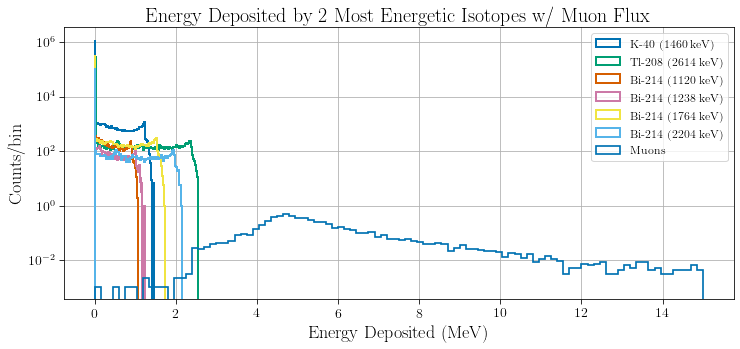

In [6]:
plt.figure(figsize=(12,5))

# Plot the gamma spectra
plt.hist(np.array(energyDeposited1460), bins=100, histtype="step", lw=2, label = "K-40 (1460 keV)")
plt.hist(np.array(energyDeposited2614), bins=100, histtype="step", lw=2, label = "Tl-208 (2614 keV)")
plt.hist(np.array(energyDeposited1120), bins=100, histtype="step", lw=2, label = "Bi-214 (1120 keV)")
plt.hist(np.array(energyDeposited1238), bins=100, histtype="step", lw=2, label = "Bi-214 (1238 keV)")
plt.hist(np.array(energyDeposited1764), bins=100, histtype="step", lw=2, label = "Bi-214 (1764 keV)")
plt.hist(np.array(energyDeposited2204), bins=100, histtype="step", lw=2, label = "Bi-214 (2204 keV)")


# Plot the muon spectrum
plt.hist(np.array(muonsEnergy), bins = 100, range = (0,15), histtype="step", lw = 1.7, label = "Muons", density = True);

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.title("Energy Deposited by 2 Most Energetic Isotopes w/ Muon Flux")
# plt.savefig("MuonsGammasFluxSim.jpg")
plt.show()

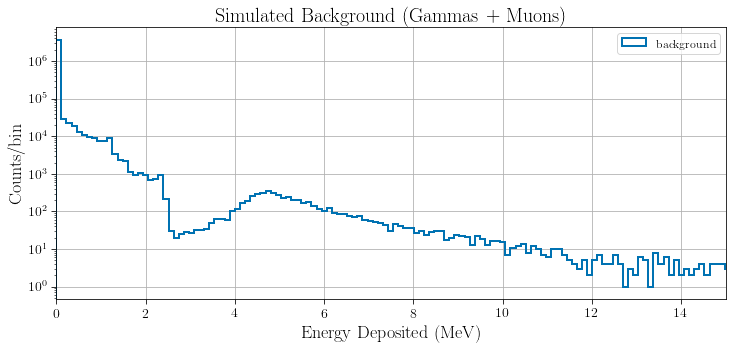

In [7]:
plt.figure(figsize=(12,5))

# Plot the gamma spectra
plt.hist(np.array(sim_mev), bins=300, histtype="step", lw=2, label = "background");

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.xlim(0,15)
plt.title("Simulated Background (Gammas + Muons)")
# plt.savefig("MuonsGammasFluxSimForCUORE.jpg")
plt.show()

### Load and read lab data from directory

In [8]:
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


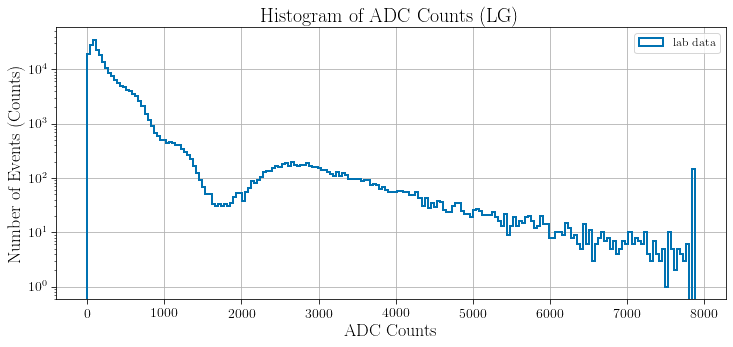

In [9]:
plt.figure(figsize=(12,5))

plt.hist(data['data']['low_gain']-ped, bins=200, lw = 2, label='lab data', histtype='step')

# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts (LG)')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

In [10]:
# Declare constants for conversion from ADC to PE/MeV

adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

In [11]:
# Convert lab data to MeV

d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV

<Figure size 864x360 with 0 Axes>

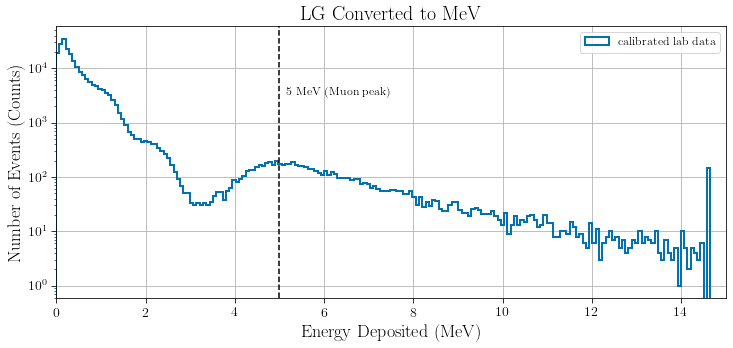

In [12]:
plt.figure(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,5))

plt.hist(lab_mev, bins=200, histtype='step', lw = 2, label='calibrated lab data')

trans = ax.get_xaxis_transform() # the x coords of this transformation are data, and the y coord are axes
plt.axvline(5, color='k', linestyle='--')
plt.text(5.15,0.75,'5 MeV (Muon peak)',transform=trans)

plt.xlim(0,15)
# plt.ylim(0,1000)
plt.xlabel('Energy Deposited (MeV)')
plt.ylabel('Number of Events (Counts)')
plt.title('LG Converted to MeV')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### Smearing first attempt (Constant sigma)

Using the sigma calculated from the gaussian Cs-137 fit, I applied smearing using the following function as a sort of “first pass.”

Because we are applying smearing in PE but the plot is in MeV, I am converting smearing to PE first when applying it, and then back to MeV for the plot, hence the *pe_mev multiplication.

Here is the first attempt with a “constant” smearing. Of course, smearing is not necessarily constant with energy, so for my second attempt I will try modeling it linearly and see what happens.

In [13]:
sim_pe = sim_mev * pe_mev

<Figure size 864x864 with 0 Axes>

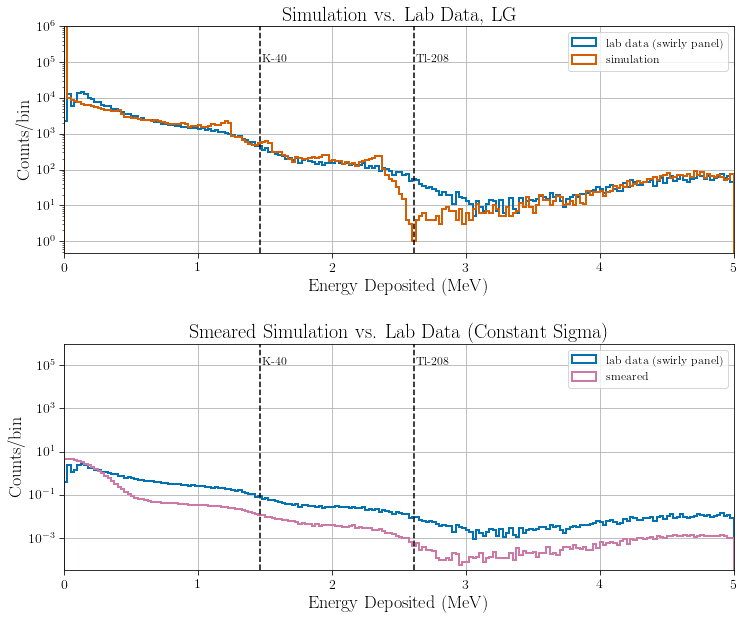

In [14]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

mugam_cut = 5.0 # separation between muon peak and gamma bg
lv = 10**5

#apply smearing
bg_smeared = np.random.normal(loc=sim_mev * pe_mev, scale = sigma_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2, density=True) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2, density=True) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smeared Simulation vs. Lab Data (Constant Sigma)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("SimulationAndSmearedFirstAttempt-moreFeqs.jpg")

plt.show()

### Smearing second attempt (linear sigma)

<Figure size 864x1440 with 0 Axes>

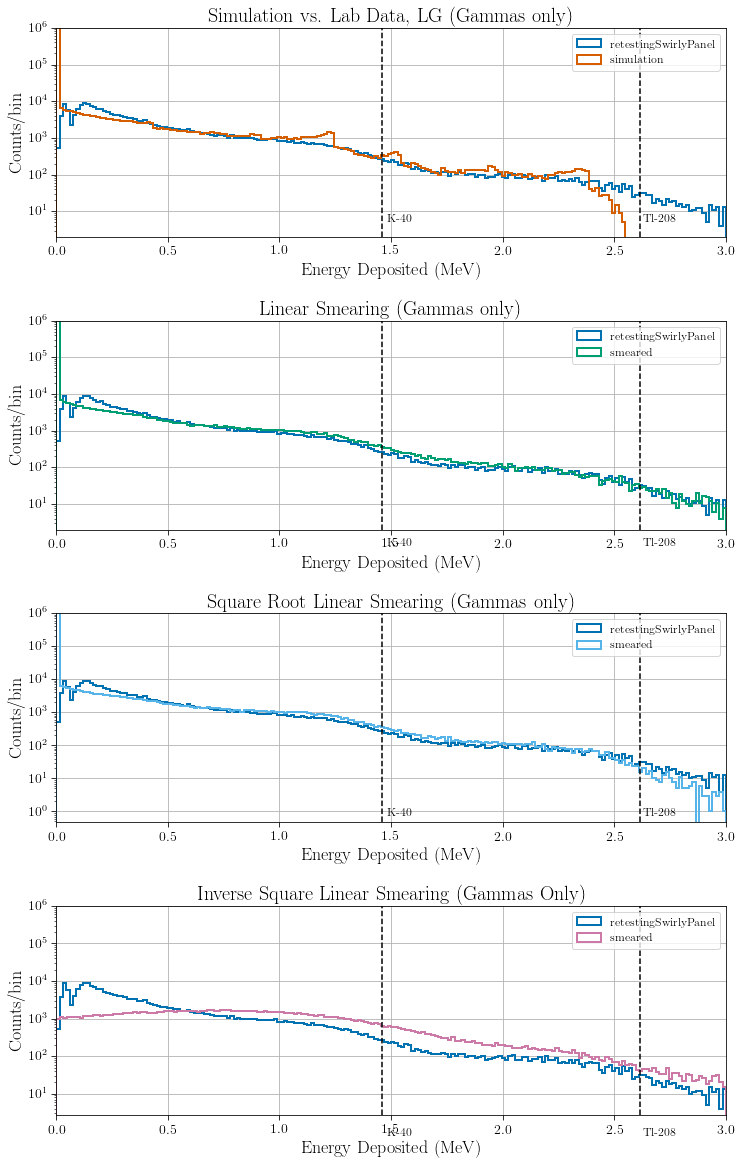

In [15]:
plt.figure(figsize=(12,20))
fig, axs = plt.subplots(2,2,figsize=(12,20))

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

mugam_cut = 3.0 # separation between muon peak and gamma bg

#apply smearing
bg_smeared_lin = np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe)
bg_smeared_nor = np.random.normal(loc=sim_pe, scale = 0.25 * np.power(lin_sigma_pe * sim_pe, 0.5))
bg_smeared_inv = np.random.normal(loc=sim_pe, scale = 400 * np.power(lin_sigma_pe * sim_pe, -0.5))


# Plot 2: Gamma simulation + lab data, gamma smearing + lab data

plt.subplot(411)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(g_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,5,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,5,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Gammas only)')

#

plt.subplot(414)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_inv/pe_mev, bins=200, range=(0.001, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Inverse Square Linear Smearing (Gammas Only)')

#

plt.subplot(412)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Linear Smearing (Gammas only)')

#

plt.subplot(413)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_nor/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Square Root Linear Smearing (Gammas only)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("SimulationAndSmearedMultipleAttempt2.jpg")

plt.show()

### Smearing third attempt (quadratic sigma)

<Figure size 864x864 with 0 Axes>

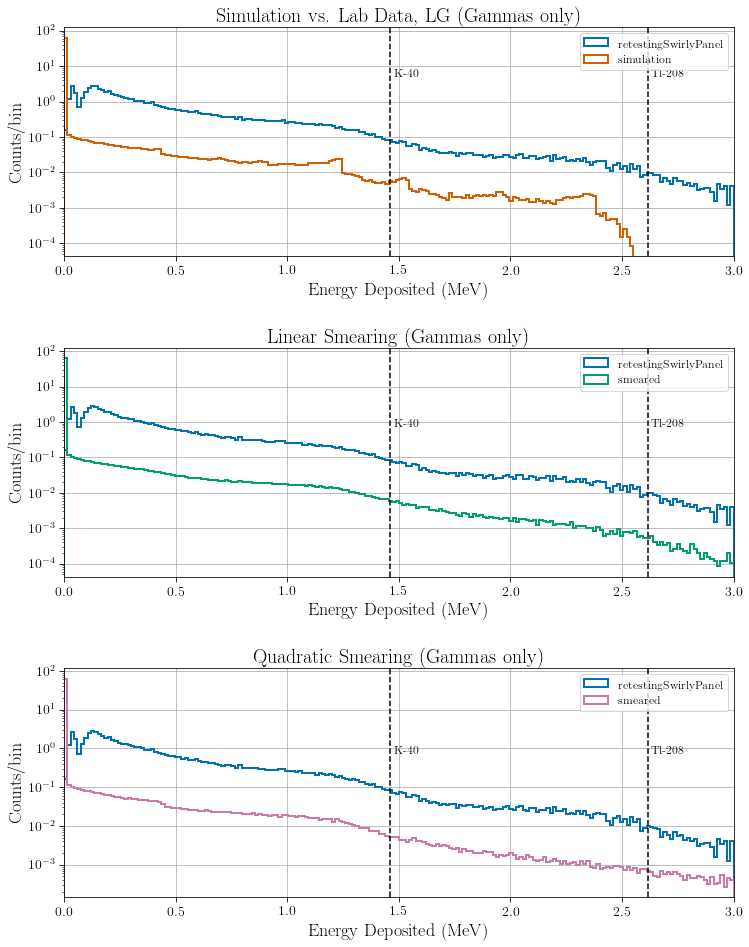

In [16]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(2,1,figsize=(12,16))

mugam_cut = 3.0 # separation between muon peak and gamma bg

#apply smearing
bg_smeared_lin = np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe)
bg_smeared_qua = np.random.normal(loc=sim_pe, scale = 0.00001 * lin_sigma_pe * sim_pe + 0.00001 * np.power(lin_sigma_pe * sim_pe, 2))

# Plot 3: Gamma simulation + lab data, gamma smearing + lab data

plt.subplot(311)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2, density = True) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2, density = True) #Plot empty hists to change color
plt.hist(g_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2, density=True) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,5,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,5,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.title('Simulation vs. Lab Data, LG (Gammas only)')

#

plt.subplot(312)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2, density = True) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2, density=True) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Linear Smearing (Gammas only)')

#

plt.subplot(313)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2, density = True) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2, density = True) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2, density = True) #Plot empty hists to change color
plt.hist(bg_smeared_qua/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2, density=True) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Quadratic Smearing (Gammas only)')

plt.subplots_adjust(hspace=0.4)

plt.savefig("SimulationAndSmearedThirdAttempt.jpg")

plt.show()

### Smearing fourth attempt (with 1/sigma factor for normalization)

<Figure size 864x864 with 0 Axes>

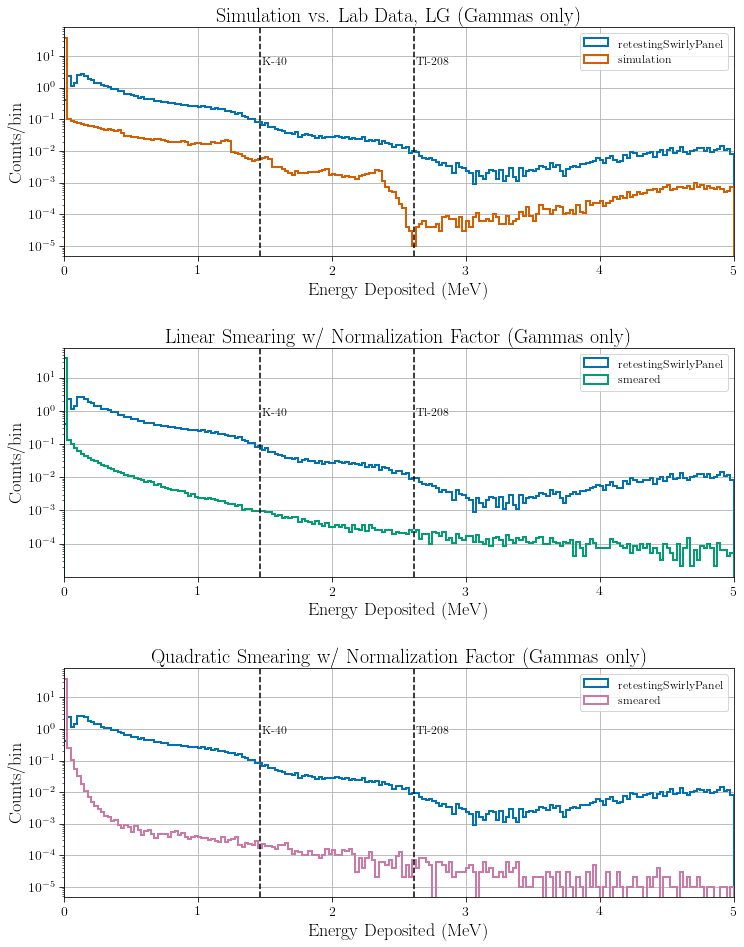

In [17]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(2,1,figsize=(12,16))

mugam_cut = 5.0 # separation between muon peak and gamma bg

#apply smearing
bg_smeared_lin = (1/lin_sigma_pe) * np.random.normal(loc=sim_pe, scale = 0.5 * lin_sigma_pe * sim_pe)
bg_smeared_qua = 0.5 * (1/lin_sigma_pe) * np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe + 0.0001 * np.power(lin_sigma_pe * sim_pe, 2))

# Plot 4: Gamma simulation + lab data, gamma smearing + lab data

plt.subplot(311)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2, density = True) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2, density = True) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2, density=True) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,5,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,5,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.title('Simulation vs. Lab Data, LG (Gammas only)')

#

plt.subplot(312)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2, density = True) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2, density=True) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Linear Smearing w/ Normalization Factor (Gammas only)')

#

plt.subplot(313)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2, density = True) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2, density = True) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2, density = True) #Plot empty hists to change color
plt.hist(bg_smeared_qua/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2, density=True) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Quadratic Smearing w/ Normalization Factor (Gammas only)')

plt.subplots_adjust(hspace=0.4)

plt.savefig("SimulationAndSmearedFourthAttempt.jpg")

plt.show()

### Smearing fifth attempt (better normalization, more attempts)

<Figure size 864x1440 with 0 Axes>

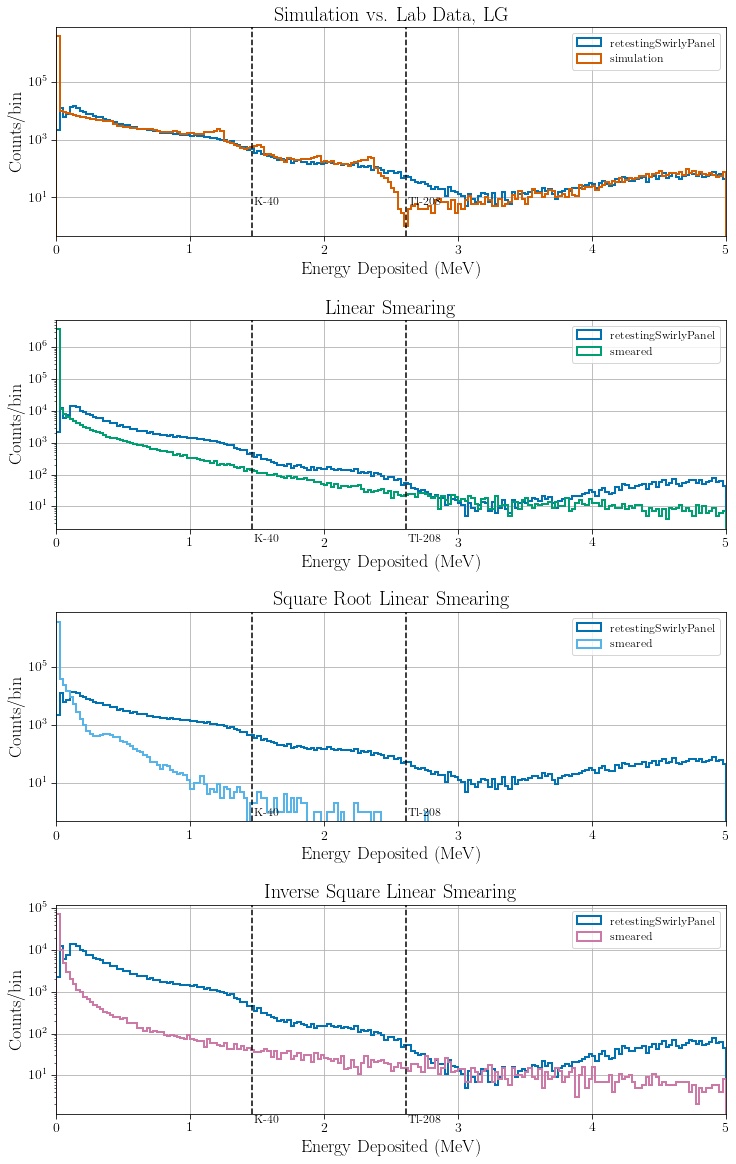

In [18]:
plt.figure(figsize=(12,20))
fig, axs = plt.subplots(2,2,figsize=(12,20))

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE
sigma_fun = lin_sigma_pe * sim_pe 

mugam_cut = 5.0 # separation between muon peak and gamma bg

#apply smearing
bg_smeared_lin = (1/lin_sigma_pe) * np.random.normal(loc=sim_pe, scale = 0.65 * sigma_fun)
bg_smeared_nor = (1/lin_sigma_pe) * np.random.normal(loc=sim_pe, scale = np.power(sigma_fun, 0.5))
bg_smeared_inv = (1/sigma_fun) * np.random.normal(loc=sim_pe, scale = 4000 * np.power(sigma_fun, -0.5))


# Plot 4: Gamma simulation + lab data, gamma smearing + lab data

plt.subplot(411)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,5,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,5,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.title('Simulation vs. Lab Data, LG')

#

plt.subplot(414)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_inv/pe_mev, bins=200, range=(0.001, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Inverse Square Linear Smearing')

#

plt.subplot(412)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Linear Smearing')

#

plt.subplot(413)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_nor/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Square Root Linear Smearing')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("SimulationAndSmearedMultipleAttempt5.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

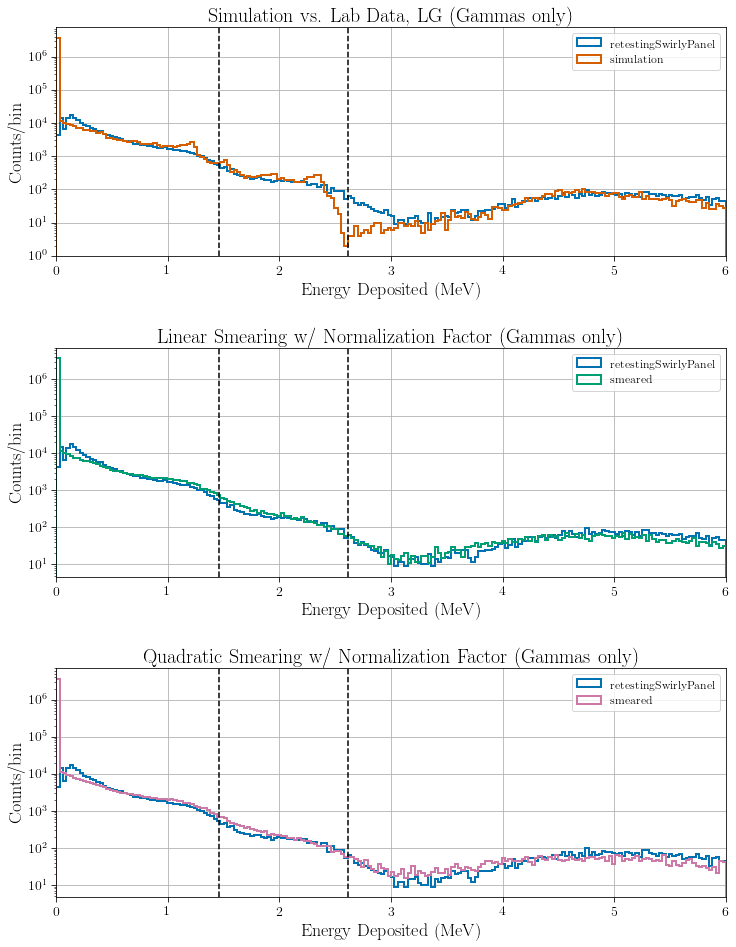

In [19]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(2,1,figsize=(12,16))

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE
sigma_fun = lin_sigma_pe * sim_pe 

mugam_cut = 6.0 # separation between muon peak and gamma bg

#apply smearing
# bg_smeared_lin = (1/lin_sigma_pe) * np.random.normal(loc=sim_pe, scale = 0.45 * sigma_fun + 3)
bg_smeared_lin = np.random.normal(loc=sim_pe, scale = 0.01 * sigma_fun)
# bg_smeared_qua = (1/sigma_fun) * np.random.normal(loc=sim_pe, scale = 2 + 22 * sigma_fun + 5 * np.power(sim_pe, 2))
# bg_smeared_qua = (1/sigma_fun) * np.random.normal(loc=sim_pe, scale = 0.5 * sigma_fun + 0.1 * np.power(sigma_fun, 2))
bg_smeared_qua = np.random.normal(loc=sim_pe, scale = 0.01 * sigma_fun + 0.00001 * lin_sigma_pe * np.power(sim_pe, 2))


# Plot 4: Gamma simulation + lab data, gamma smearing + lab data

plt.subplot(311)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
# plt.text(1.48,5,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
# plt.text(2.63,5,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.title('Simulation vs. Lab Data, LG (Gammas only)')

#

plt.subplot(312)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
# plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
# plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Linear Smearing w/ Normalization Factor (Gammas only)')

#

plt.subplot(313)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='retestingSwirlyPanel', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_qua/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
# plt.text(1.48,0.7,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
# plt.text(2.63,0.7,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title('Quadratic Smearing w/ Normalization Factor (Gammas only)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("SimulationAndSmearedSixthAttempt.jpg")

plt.show()